In [1]:
from dask_jobqueue import *
from dask.distributed import *
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import netCDF4 
from dask import delayed
from dask import compute
from dask.diagnostics import*
from tqdm import tqdm
import dask
import os, sys, glob
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import config 
import gc
import warnings
warnings.filterwarnings('ignore')

In [10]:
## Data handlers
from dask_jobqueue import *
from dask.distributed import *
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import netCDF4 
from dask import delayed
from dask import compute
from dask.diagnostics import*
from tqdm import tqdm
import dask
## Plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import matplotlib.colors as mcl
from mpl_toolkits import axes_grid1
import seaborn as sns
import matplotlib.dates as mdates
import geopandas
import rioxarray
from shapely.geometry import mapping
## Global config
import os, sys, glob
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import config 
import gc
import warnings
warnings.filterwarnings('ignore')


In [11]:
#from dask.distributed import Client
client = Client() 
client

<Client: 'tcp://127.0.0.1:37535' processes=4 threads=4, memory=202.30 GB>

In [3]:
spinup1_path = '/home/civil/phd/cez218606/LISF1/merra2_run/output/LIS_MERRA_spinup/SURFACEMODEL/*/*HIST*'
spinup2_path = '/home/civil/phd/cez198621/projects/datasets/simulations/LIS_MERRA2_Spinup2/SURFACEMODEL/*/*HIST*'

In [4]:
spinup1_surfacemodel = xr.open_mfdataset(spinup1_path,combine='by_coords',parallel=True)

In [5]:
spinup2_surfacemodel = xr.open_mfdataset(spinup2_path,combine='by_coords',parallel=True)

In [19]:
spinup1_surfacemodel

<xarray.Dataset>
Dimensions:           (time: 1826, north_south: 320, east_west: 300, SoilMoist_profiles: 4)
Coordinates:
  * time              (time) datetime64[ns] 1981-01-02 1981-01-03 ... 1986-01-01
Dimensions without coordinates: north_south, east_west, SoilMoist_profiles
Data variables: (12/19)
    lat               (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    lon               (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    Swnet_tavg        (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    Lwnet_tavg        (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    Qle_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    Qh_tavg           (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    ...                ...
    SnowDepth_inst    (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    SoilMoist_tavg    (time, SoilMoist_profiles, north_south, east_west) float32 dask.array<chunksize=(1, 4, 320, 300), meta=np.ndarray>
    WaterTableD_tavg  (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    TWS_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    GWS_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
    TotalPrecip_tavg  (time, north_south, east_west) float32 dask.array<chunksize=(1, 320, 300), meta=np.ndarray>
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNESSES:  [0.1 0.3 0.6 1. ]
    title:                   LIS land surface model output
    institution:             NASA GSFC
    source:                  
    ...                      ...
    comment:                 website: http://lis.gsfc.nasa.gov/
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:   5.55
    SOUTH_WEST_CORNER_LON:   68.05
    DX:                      0.1
    DY:                      0.1

In [20]:
mask = geopandas.read_file('/home/civil/phd/cez218606/LISF1/merra2_run/output/pyLISF/shapefiles/india_basins/narmada.shp')

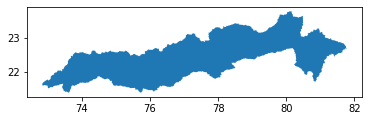

In [21]:
mask.plot()

In [22]:

lsm1 = config.reformat_LIS_output(spinup1_surfacemodel)
lsm1.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
lsm1.rio.write_crs("epsg:4326", inplace=True)
lsm_clip = lsm1.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

In [25]:

lsm2 = config.reformat_LIS_output(spinup2_surfacemodel)
lsm2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
lsm2.rio.write_crs("epsg:4326", inplace=True)
lsm_clip1 = lsm2.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

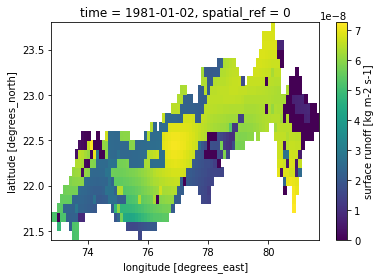

In [24]:
lsm_clip.Qs_tavg[0].plot()

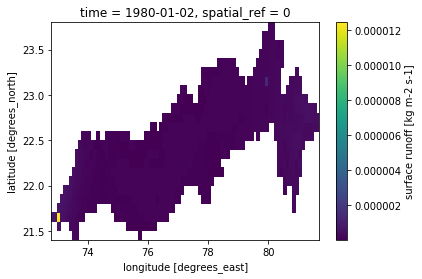

In [26]:
lsm_clip1.Qs_tavg[0].plot()

In [27]:
var_list = ['SoilMoist_tavg','TWS_tavg','Qs_tavg']

In [28]:
for var in var_list:
    var1 = lsm_clip[var]
    var2 = lsm_clip1[var]
    var1_mean = var1.mean().values
    var2_mean = var2.mean().values
    var1_min = var1.min().values
    var2_min = var2.min().values
    var1_max = var1.max().values
    var2_max = var2.max().values
    percent_diff = ((var1-var2)/((var1+var2)/2))*100
    avg_percent_diff =  percent_diff.mean().values
    print('Mean value for ',var,' in spinup1 :',var1_mean.item())
    print('Mean value for ',var,' in spinup2 :',var2_mean.item())
    print('Min value for ',var,' in spinup1 :',var1_min.item())
    print('Min value for ',var,' in spinup2 :',var2_min.item())
    print('Max value for ',var,' in spinup1 :',var1_max.item())
    print('Max value for ',var,' in spinup2 :',var2_max.item())
    print('Average percentage difference for ',var,' in two spinups:',avg_percent_diff.item())

Mean value for  SoilMoist_tavg  in spinup1 : 176.36073303222656
Mean value for  SoilMoist_tavg  in spinup2 : 176.5161895751953
Min value for  SoilMoist_tavg  in spinup1 : 4.945720195770264
Min value for  SoilMoist_tavg  in spinup2 : 4.945662975311279
Max value for  SoilMoist_tavg  in spinup1 : 467.5696716308594
Max value for  SoilMoist_tavg  in spinup2 : 467.5857849121094
Average percentage difference for  SoilMoist_tavg  in two spinups: 0.059842661023139954
Mean value for  TWS_tavg  in spinup1 : 5595.07958984375
Mean value for  TWS_tavg  in spinup2 : 5597.056640625
Min value for  TWS_tavg  in spinup1 : 5103.9248046875
Min value for  TWS_tavg  in spinup2 : 5103.94970703125
Max value for  TWS_tavg  in spinup1 : 5927.67138671875
Max value for  TWS_tavg  in spinup2 : 5933.06005859375
Average percentage difference for  TWS_tavg  in two spinups: 0.04298242926597595
Mean value for  Qs_tavg  in spinup1 : 4.564751634461572e-06
Mean value for  Qs_tavg  in spinup2 : 5.104234332975466e-06
Min val

In [34]:
spinup1_path = '/home/civil/phd/cez218606/LISF1/merra2_run/output/LIS_MERRA_spinup/ROUTING/*/*HIST*'
spinup2_path = '/home/civil/phd/cez198621/projects/datasets/simulations/LIS_MERRA2_Spinup2/ROUTING/*/*HIST*'

In [35]:
spinup1_surfacemodel = xr.open_mfdataset(spinup1_path,combine='by_coords',parallel=True)
spinup2_surfacemodel = xr.open_mfdataset(spinup2_path,combine='by_coords',parallel=True)

In [36]:

lsm1 = config.reformat_LIS_output(spinup1_surfacemodel)
lsm1.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
lsm1.rio.write_crs("epsg:4326", inplace=True)
lsm_clip = lsm1.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

In [37]:

lsm2 = config.reformat_LIS_output(spinup2_surfacemodel)
lsm2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
lsm2.rio.write_crs("epsg:4326", inplace=True)
lsm_clip1 = lsm2.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

In [39]:
lsm_clip

<xarray.Dataset>
Dimensions:           (lat: 24, lon: 89, time: 1826)
Coordinates:
  * lat               (lat) float64 21.45 21.55 21.65 ... 23.55 23.65 23.75
  * lon               (lon) float64 72.85 72.95 73.05 ... 81.45 81.55 81.65
  * time              (time) datetime64[ns] 1981-01-02 1981-01-03 ... 1986-01-01
    spatial_ref       int64 0
Data variables:
    Streamflow_tavg   (time, lat, lon) float32 dask.array<chunksize=(1, 24, 89), meta=np.ndarray>
    RiverStor_tavg    (time, lat, lon) float32 dask.array<chunksize=(1, 24, 89), meta=np.ndarray>
    RiverDepth_tavg   (time, lat, lon) float32 dask.array<chunksize=(1, 24, 89), meta=np.ndarray>
    FloodedFrac_tavg  (time, lat, lon) float32 dask.array<chunksize=(1, 24, 89), meta=np.ndarray>
    SWS_tavg          (time, lat, lon) float32 dask.array<chunksize=(1, 24, 89), meta=np.ndarray>
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         1
    SOIL_LAYER_THICKNESSES:  1.0
    title:                   LIS land surface model output
    institution:             NASA GSFC
    source:                  model_not_specified
    ...                      ...
    comment:                 website: http://lis.gsfc.nasa.gov/
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:   5.55
    SOUTH_WEST_CORNER_LON:   68.05
    DX:                      0.1
    DY:                      0.1

In [45]:
gauge_lat = 22.17   #22.49
gauge_lon = 75.66  #76.99

In [46]:
new_rout = lsm_clip.sel(lat=gauge_lat,lon=gauge_lon,method='nearest')
old_rout = lsm_clip1.sel(lat=gauge_lat,lon=gauge_lon,method='nearest')

In [47]:
var_list = ['Streamflow_tavg']

In [48]:
for var in var_list:
    var1 = new_rout[var]
    var2 = old_rout[var]
    var1_mean = var1.mean().values
    var2_mean = var2.mean().values
    var1_min = var1.min().values
    var2_min = var2.min().values
    var1_max = var1.max().values
    var2_max = var2.max().values
    percent_diff = ((var1-var2)/((var1+var2)/2))*100
    avg_percent_diff =  percent_diff.mean().values
    print('Mean value for ',var,' in spinup_new :',var1_mean.item())
    print('Mean value for ',var,' in spinup_old :',var2_mean.item())
    print('Min value for ',var,' in spinup_new :',var1_min.item())
    print('Min value for ',var,' in spinup_old :',var2_min.item())
    print('Max value for ',var,' in spinup_new :',var1_max.item())
    print('Max value for ',var,' in spinup_old :',var2_max.item())
    print('Average percentage difference for ',var,' in two spinups:',avg_percent_diff.item())

Mean value for  Streamflow_tavg  in spinup_new : 1328.679931640625
Mean value for  Streamflow_tavg  in spinup_old : 1468.2266845703125
Min value for  Streamflow_tavg  in spinup_new : 118.3426513671875
Min value for  Streamflow_tavg  in spinup_old : 118.18648529052734
Max value for  Streamflow_tavg  in spinup_new : 13243.0341796875
Max value for  Streamflow_tavg  in spinup_old : 13080.4091796875
Average percentage difference for  Streamflow_tavg  in two spinups: 2.1205544471740723


In [49]:
for var in var_list:
    var1 = lsm_clip[var]
    var2 = lsm_clip1[var]
    var1_mean = var1.mean().values
    var2_mean = var2.mean().values
    var1_min = var1.min().values
    var2_min = var2.min().values
    var1_max = var1.max().values
    var2_max = var2.max().values
    percent_diff = ((var1-var2)/((var1+var2)/2))*100
    avg_percent_diff =  percent_diff.mean().values
    print('Mean value for ',var,' in spinup_new :',var1_mean.item())
    print('Mean value for ',var,' in spinup_old :',var2_mean.item())
    print('Min value for ',var,' in spinup_new :',var1_min.item())
    print('Min value for ',var,' in spinup_old :',var2_min.item())
    print('Max value for ',var,' in spinup_new :',var1_max.item())
    print('Max value for ',var,' in spinup_old :',var2_max.item())
    print('Average percentage difference for ',var,' in two spinups:',avg_percent_diff.item())

Mean value for  Streamflow_tavg  in spinup_new : 137.85231018066406
Mean value for  Streamflow_tavg  in spinup_old : 153.67559814453125
Min value for  Streamflow_tavg  in spinup_new : -16.65767478942871
Min value for  Streamflow_tavg  in spinup_old : -38.44834518432617
Max value for  Streamflow_tavg  in spinup_new : 13911.75
Max value for  Streamflow_tavg  in spinup_old : 13776.0703125
Average percentage difference for  Streamflow_tavg  in two spinups: -0.6051320433616638
